# Modeling

The goal of this notebook is to train a model that can reliably predict a simulated value for volatility based on variables such as volume, cpi, unemployment, interest rates, consumer confidence, etc.

Neural networks may not be especially effective for this application given the limited amount of data, though their efficacy will still be evaluated.

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('data/data_engineered.csv')
df = df.drop(columns=['Unnamed: 0','Date', 'Date.1', 'High', 'Low'])
df = df.dropna()
df.head()

,Open,Close,Volume,cpi,unemployment,consumer_confidence,interest_rate,log_returns,range,volatility,volume_ma
6,178.472086,167.626038,3734926900,238.316,5.1,91.9,0.14,-0.062887,24.515958,0.033536,2.567009e+09
7,163.767554,162.504028,3279512900,237.945,5.0,87.2,0.14,-0.031033,13.534234,0.034528,2.655274e+09
8,163.732453,177.243271,2536184400,237.838,5.0,90.0,0.12,0.086820,17.321140,0.052901,2.738524e+09
9,177.575768,177.891159,1924512800,237.336,5.1,91.3,0.12,0.003649,8.080934,0.052634,2.743856e+09
10,178.530461,173.782486,2924882300,236.525,5.0,92.6,0.24,-0.023367,9.521509,0.052449,2.808796e+09


In [80]:
# train, test, split
from sklearn.model_selection import train_test_split

y = df['volatility']
X = df.drop(columns='volatility')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [81]:
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# define models

models = {
    "XGBoost" : XGBRegressor(),
    "Random Forest" : RandomForestRegressor(),
    "Support Vector Regression" : SVR(),
    "KNN Regression" : KNeighborsRegressor()
}

Here, the models are evaluated using k-folds cross validation.

The scoring metric is negative mean absolute error, which will  (INSERT EXPLANATION)

In [82]:
from sklearn.model_selection import cross_validate

for name, model in models.items():
    cv_result = cross_validate(model, X, y, cv=5, scoring='neg_mean_absolute_error')
    scores = cv_result["test_score"]
    print(f'{name} Mean CV Accuracy: {scores.mean():.3f} ± {scores.std():.3f}\n')

XGBoost Mean CV Accuracy: -0.020 ± 0.009

Random Forest Mean CV Accuracy: -0.021 ± 0.010

Support Vector Regression Mean CV Accuracy: -0.020 ± 0.003

KNN Regression Mean CV Accuracy: -0.016 ± 0.003



Next, model performance will be evaluated using k-folds cross validation again, but this time with r-squared

In [83]:
for name, model in models.items():
    cv_result = cross_validate(model, X, y, cv=5, scoring='r2')
    scores = cv_result["test_score"]
    print(f'{name} Mean CV Accuracy: {scores.mean():.3f} ± {scores.std():.3f}\n')

XGBoost Mean CV Accuracy: -1.065 ± 1.677

Random Forest Mean CV Accuracy: -1.635 ± 2.780

Support Vector Regression Mean CV Accuracy: -0.978 ± 0.935

KNN Regression Mean CV Accuracy: -0.361 ± 0.851



In [84]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor

param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'metric': ['euclidean', 'manhattan']
}

knn_regressor = KNeighborsRegressor()
grid_search = GridSearchCV(knn_regressor, param_grid, cv=5, scoring='r2')  # Change to 'r2' for r2 score
grid_search.fit(X, y)

print("Best Hyperparameters:", grid_search.best_params_)
print("Best CV Score:", grid_search.best_score_)


Best Hyperparameters: {'metric': 'manhattan', 'n_neighbors': 9}
Best CV Score: 0.033595381229241064


C:\Users\Sean\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0021. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


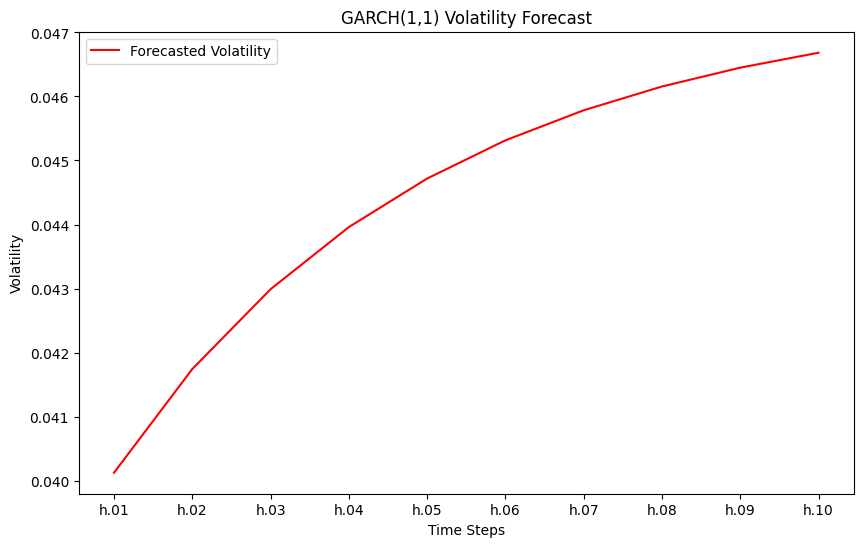

Forecasted Volatility (Standard Deviation) for next 10 periods:
         h.01      h.02     h.03     h.04      h.05      h.06      h.07  \
117  0.040123  0.041742  0.04299  0.04396  0.044718  0.045315  0.045785   

         h.08     h.09      h.10  
117  0.046156  0.04645  0.046684  


In [87]:
import pandas as pd
import numpy as np
from arch import arch_model
import matplotlib.pyplot as plt

# Load your data (assuming 'returns' is your column for returns)
# Example: data = pd.read_csv('your_data.csv')

# For illustration, let's simulate some data
np.random.seed(42)
returns = df['log_returns']  # Simulating some returns data

# Step 1: Fit a GARCH model to your returns data
model = arch_model(returns, vol='Garch', p=1, q=1)  # GARCH(1,1) model
model_fit = model.fit(disp="off")

# Step 2: Forecast the volatility (standard deviation of returns) for the next 10 periods
forecast = model_fit.forecast(horizon=10)
volatility_forecast = forecast.variance[-1:] ** 0.5  # Taking the square root to get standard deviation

# Step 3: Visualize the volatility forecast
plt.figure(figsize=(10,6))
plt.plot(volatility_forecast.T, label='Forecasted Volatility', color='red')
plt.title('GARCH(1,1) Volatility Forecast')
plt.xlabel('Time Steps')
plt.ylabel('Volatility')
plt.legend()
plt.show()

# Print out the last forecasted volatility
print("Forecasted Volatility (Standard Deviation) for next 10 periods:")
print(volatility_forecast)
